### Importy

In [1]:
pip install shap timeshap ta optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.2 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=a085a06ad8dc503757c644c2be5f0f506fe36407d9d1a8ad984e01f768099db7
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, InputLayer
from keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, InputLayer, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, auc
import tensorflow as tf
from tensorflow.keras import backend as K
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import shap
from scripts.train_utilities import *
from scripts.essentials import *
from scripts.plots import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, InputLayer
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

In [3]:
#tf.compat.v1.disable_v2_behavior()

In [157]:
train_set = pd.read_csv('train_set_full.csv')
test_set = pd.read_csv('test_set_full.csv')
val_set = pd.read_csv('val_set_full.csv')

In [158]:
prefix = "TSLA"

### Funkcje

In [67]:
def train_model_from_params(params, X, y, X_val, y_val):
  # Create the model
  model = Sequential()

  # Add Conv1D layer if use_conv is True
  if params['use_conv']:
      model.add(Conv1D(filters=params['conv_filters'],
                      kernel_size=params['conv_kernel_size'],
                      activation='relu',
                      input_shape=(X.shape[1], X.shape[2])))
      model.add(MaxPooling1D(pool_size=2))

  # Add LSTM layers
  for i in range(params['n_layers']):
      model.add(LSTM(units=params[f'lstm_units_{i}'],
                    return_sequences=(i < params['n_layers'] - 1)))

  # Add Dense layer and output layer
  model.add(Dense(units=params['dense_units'], activation='relu'))
  model.add(Dense(units=1))

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mean_squared_error',metrics=[CustomAUCMetric()])

  # Train the model
  early_stopping = EarlyStopping(monitor='val_custom_auc', patience=40, mode='max', restore_best_weights=True)

  history = model.fit(X, y, epochs=350, validation_data=(X_val, y_val),
                          callbacks=[early_stopping])

  return model

class CustomAUCMetric(tf.keras.metrics.Metric):
    def __init__(self, name="custom_auc", **kwargs):
        super(CustomAUCMetric, self).__init__(name=name, **kwargs)
        self.auc = tf.keras.metrics.AUC(from_logits=True)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_binary = K.cast(K.greater(y_true, 0), 'float32')
        y_pred_binary = K.cast(K.greater(y_pred, 0), 'float32')
        self.auc.update_state(y_true_binary, y_pred_binary, sample_weight)

    def result(self):
        return self.auc.result()

    def reset_state(self):
        self.auc.reset_states()

def c_f1_score(y_true, y_pred):
    csm = count_signs_matrix(y_true, y_pred)
    #print(csm)
    return (3*csm[1][1]/(csm[1][0]+csm[1][1]+0.001) + 2*csm[1][1]/(csm[0][1]+csm[1][1]+0.001))/5

def custom_f1_metric(y_true, y_pred):
    # Convert y_pred to the same type as y_true
    y_pred = K.cast(y_pred, y_true.dtype)

    # Transform regression outputs to 1 and -1 based on sign
    y_true_binary = K.cast(K.greater(y_true, 0), 'float32')
    y_pred_binary = K.cast(K.greater(y_pred, 0), 'float32')

    # Calculate F1 score
    # Since F1 score is a metric from sklearn, we use tf.py_function to wrap it
    return tf.py_function(c_f1_score, (y_true_binary, y_pred_binary), tf.double)

def custom_auc_metric(y_true, y_pred):
    # Convert y_pred to the same type as y_true
    y_pred = K.cast(y_pred, y_true.dtype)

    # Transform regression outputs to 0 and 1 based on sign
    y_true_sign = K.sign(y_true)
    y_pred_sign = K.sign(y_pred)

    # Use TensorFlow's AUC metric
    return tf.py_function(auc, (y_true_sign, y_pred_sign), tf.double)


def create_model(trial, input_shape):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))

    # Optionally add a convolutional layer before LSTM
    if trial.suggest_categorical('use_conv', [True, False]):
        model.add(Conv1D(filters=trial.suggest_categorical('conv_filters', [32, 64, 128]),
                         kernel_size=trial.suggest_int('conv_kernel_size', 2, 5),
                         activation='relu',
                         strides=1,
                      padding='causal'))
        model.add(MaxPooling1D(pool_size=2))

    # Optuna can suggest the number of LSTM layers and units
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        model.add(LSTM(units=trial.suggest_categorical(f'lstm_units_{i}', [16, 32, 64]),
                       return_sequences=(i < n_layers - 1)))

    model.add(Dense(units=trial.suggest_categorical('dense_units', [8, 16, 32]), activation='relu'))
    model.add(Dense(units=1))

    # Compile model
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error',metrics=[CustomAUCMetric()])

    return model

def objective(trial):
    model = create_model(trial, input_shape=(X.shape[1], X.shape[2]))

    early_stopping = EarlyStopping(monitor='val_custom_auc', patience=35, mode='max', restore_best_weights=True)

    history = model.fit(X, y, epochs=200, validation_data=(X_val, y_val),
                        callbacks=[early_stopping], verbose=0)

    # Evaluate the model
    val_loss, val_f1 = model.evaluate(X_val, y_val, verbose=0)
    return val_f1

def get_x_y(train_set,
            val_set,
            test_set,
            cols_used,
            target_cols= ['target_5'],
            window_size=10,
            shift_=5):

  X,y = window_dataset(train_set[list(cols_used)+target_cols],  target_cols[0], window_size)
  X_val, y_val = window_dataset(val_set[list(cols_used)+target_cols], target_cols[0], window_size)
  X_test, y_test = window_dataset(test_set[list(cols_used)+target_cols], target_cols[0], window_size)

  y_test = y_test[:-shift_]

  y_base_val = val_set[target_cols[0]].shift(shift_)[window_size:].values
  y_base_test = test_set[target_cols[0]].shift(shift_)[window_size:-shift_].values
  y_base_train = train_set[target_cols[0]].shift(shift_)[window_size:].values
  y_base0_val = [0 for i in range((val_set.shape[0]-window_size))]
  y_base0_train = [0 for i in range((train_set.shape[0]-window_size))]
  y_base0_test = [0 for i in range(len(y_test))]

  return X,y,X_val,y_val,X_test,y_test,y_base_train,y_base_val,y_base_test,y_base0_train,y_base0_val,y_base0_test

In [8]:
def create_unique_subsets(columns, subset_size=5, min_diff=2):
    """
    Create subsets of columns where each subset differs from every other subset by at least 'min_diff' columns.

    :param columns: List of all columns.
    :param subset_size: The size of each subset.
    :param min_diff: Minimum number of different columns between any two subsets.
    :return: A list of unique subsets.
    """
    all_combinations = list(itertools.combinations(columns, subset_size))
    unique_subsets = []

    for combo in all_combinations:
        if all(len(set(combo) - set(subset)) >= min_diff for subset in unique_subsets):
            unique_subsets.append(combo)

    return unique_subsets

def make_model_better(X, y, X_val, y_val, n_epochs, lstm_units=64, dense_units=10, patience=5):
    model = Sequential()
    model.add(InputLayer(input_shape=(X.shape[1], X.shape[2])))

    # LSTM layers
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(LSTM(units=lstm_units, return_sequences=False))

    # Dense layers
    model.add(Dense(units=dense_units))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Early stopping and model checkpoint
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model.fit(X, y, epochs=n_epochs, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

    return model, history

# Example usage:
# model, history = make_model(X_train, y_train, X_val, y_val, n_epochs=50, lstm_units=64, dense_units=10, patience=5)

def window_dataset(df, target_column, window_size):
    X = []
    y = []

    # Iterate over the dataset
    for i in range(len(df) - window_size):
        # Extract the window of data
        window = df[i:i+window_size]

        # Extract the features (X) and target (y)
        X.append(window.drop(columns=[target_column]).values)
        y.append(df[target_column][i+window_size])

    return np.array(X), np.array(y)

def run_multiple_models(train_set,val_set,cols_subset,n_epochs=100):

  window_size = 14
  target_cols = ['target_7']
  mse_val = []
  mse_train = []
  aggregated_shap = []
  for idx,cols_used in enumerate(cols_subset):
    print('-------------------------------')
    print(idx)

    X,y = window_dataset(train_set[list(cols_used)+target_cols],  target_cols[0], window_size)
    X_val, y_val = window_dataset(val_set[list(cols_used)+target_cols], target_cols[0], window_size)

    model,history = make_model(X,y, X_val, y_val, n_epochs)

    mse_val.append(min(history.history['val_loss']))
    mse_train.append(min(history.history['loss']))

    explainer = shap.DeepExplainer(model, X)
    shap_values = explainer.shap_values(X_val)

    aggregated_shap.append(np.mean(np.abs(shap_values[0]), axis=0))

    #create df
    if (idx%15 == 0):
      df = pd.DataFrame({'cols_used': cols_subset[:idx+1], 'mse_val': mse_val, 'mse_train': mse_train,
                        'aggregated_shap':aggregated_shap})
      df.to_csv('df_shap'+str(idx)+'.csv')
  df = pd.DataFrame({'cols_used': cols_subset, 'mse_val': mse_val, 'mse_train': mse_train,
                        'aggregated_shap':aggregated_shap})
  df.to_csv('df_shap_final.csv')

  return df

def parse_cols_used(cols_string):
    """
    Parses the column names used in the model from the string representation.

    Args:
    cols_string (str): A string representing the tuple of column names.

    Returns:
    list: A list of column names.
    """
    # Remove the outer brackets and split the string into column names
    cols = cols_string.strip("()").split(", ")
    # Remove quotes and extra characters from column names
    cleaned_cols = [col.strip("'") for col in cols]
    return cleaned_cols

def parse_shap_values(shap_string):
    """
    Parses a string representation of a list of lists of SHAP values into a Python list of lists.

    Args:
    shap_string (str): A string representing a list of lists of SHAP values.

    Returns:
    list of lists: A list of lists of SHAP values.
    """
    # Remove the outer brackets and split the string into rows, handling newline characters
    rows = shap_string.strip('[]').split('\n')

    # Parse each row into a list of floats
    parsed_rows = [list(map(float, row.strip(' []').split())) for row in rows]

    return parsed_rows

def make_model(X, y, n_epochs, lstm_units=32,dense_units=8):
    tf.keras.backend.clear_session()

    model = Sequential()
    model.add(InputLayer(input_shape=(X.shape[1], X.shape[2])))

    # LSTM layers
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(LSTM(units=lstm_units, return_sequences=False))

    # Dense layers
    model.add(Dense(units=dense_units))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X, y, epochs=n_epochs,
                        verbose=0)

    return model, history

def plot_mean_feature_importance(shap_values, feature_names,max_=False):
    """
    Plot the mean importance of each feature across all time steps.

    :param shap_values: A 3D array of SHAP values with shape (samples, window_size, num_features).
    :param feature_names: List of feature names.
    """
    if max_:
    # Aggregate SHAP values across all samples and time steps
      aggregated_shap = np.max(np.abs(shap_values), axis=(0))
    else:
      aggregated_shap = np.mean(np.abs(shap_values), axis=(0))


    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, aggregated_shap)
    plt.title('Mean Feature Importance Across All Time Steps')
    plt.ylabel('Mean SHAP Value')
    plt.xlabel('Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Optuna

In [177]:
import random

random.seed(10)
np.random.seed(10)

# Set seed for TensorFlow
tf.random.set_seed(10)


In [159]:
window_size = 10
target_cols = ['target_5']
cols_used = [
             'minmax_low_norm', 'minmax_high_norm', 'norm_rsi_gspc_14', 'norm_slowk_14'
             ]

X,y = window_dataset(train_set[list(cols_used)+target_cols],  target_cols[0], window_size)
X_val, y_val = window_dataset(val_set[list(cols_used)+target_cols], target_cols[0], window_size)
X_test, y_test = window_dataset(test_set[list(cols_used)+target_cols], target_cols[0], window_size)

study_f = optuna.create_study(direction='maximize')
study_f.optimize(objective, n_trials=15)  # Adjust n_trials to how many trials you want to run

print(study_f.best_params)

[I 2023-12-29 14:27:19,389] A new study created in memory with name: no-name-17cafbb8-52b3-4bf2-9a9b-f27f70c16e70
[I 2023-12-29 14:28:05,530] Trial 0 finished with value: 0.7361111640930176 and parameters: {'use_conv': False, 'n_layers': 2, 'lstm_units_0': 64, 'lstm_units_1': 16, 'dense_units': 8, 'learning_rate': 0.00962812949130658}. Best is trial 0 with value: 0.7361111640930176.
[I 2023-12-29 14:28:18,303] Trial 1 finished with value: 0.4999999701976776 and parameters: {'use_conv': False, 'n_layers': 1, 'lstm_units_0': 64, 'dense_units': 16, 'learning_rate': 2.047845802877897e-05}. Best is trial 0 with value: 0.7361111640930176.
[I 2023-12-29 14:28:39,426] Trial 2 finished with value: 0.6249999403953552 and parameters: {'use_conv': True, 'conv_filters': 128, 'conv_kernel_size': 2, 'n_layers': 1, 'lstm_units_0': 32, 'dense_units': 8, 'learning_rate': 0.006188271400027266}. Best is trial 0 with value: 0.7361111640930176.
[I 2023-12-29 14:29:06,365] Trial 3 finished with value: 0.5555

{'use_conv': False, 'n_layers': 2, 'lstm_units_0': 64, 'lstm_units_1': 16, 'dense_units': 8, 'learning_rate': 0.00962812949130658}


In [175]:
window_size = 10
target_cols = ['target_5']
cols_used = [
            'vader_Score', 'bart_Score', 'mean_influential', 'finbert_Score', 'mean_trustworthy'
             ]

X,y = window_dataset(train_set[list(cols_used)+target_cols],  target_cols[0], window_size)
X_val, y_val = window_dataset(val_set[list(cols_used)+target_cols], target_cols[0], window_size)
X_test, y_test = window_dataset(test_set[list(cols_used)+target_cols], target_cols[0], window_size)

study_n = optuna.create_study(direction='maximize')
study_n.optimize(objective, n_trials=15)  # Adjust n_trials to how many trials you want to run

print(study_n.best_params)

[I 2023-12-29 14:43:11,883] A new study created in memory with name: no-name-021782d3-3f9f-466f-b454-3a7f715ee3dd
[I 2023-12-29 14:44:20,400] Trial 0 finished with value: 0.4027777910232544 and parameters: {'use_conv': True, 'conv_filters': 64, 'conv_kernel_size': 4, 'n_layers': 1, 'lstm_units_0': 64, 'dense_units': 8, 'learning_rate': 2.0800491997236765e-05}. Best is trial 0 with value: 0.4027777910232544.
[I 2023-12-29 14:44:46,978] Trial 1 finished with value: 0.5 and parameters: {'use_conv': True, 'conv_filters': 64, 'conv_kernel_size': 3, 'n_layers': 3, 'lstm_units_0': 16, 'lstm_units_1': 16, 'lstm_units_2': 64, 'dense_units': 8, 'learning_rate': 0.00030181069727217854}. Best is trial 1 with value: 0.5.
[I 2023-12-29 14:44:58,849] Trial 2 finished with value: 0.5833333730697632 and parameters: {'use_conv': False, 'n_layers': 1, 'lstm_units_0': 32, 'dense_units': 32, 'learning_rate': 0.0002732469267188306}. Best is trial 2 with value: 0.5833333730697632.
[I 2023-12-29 14:45:39,696]

{'use_conv': True, 'conv_filters': 64, 'conv_kernel_size': 3, 'n_layers': 3, 'lstm_units_0': 64, 'lstm_units_1': 32, 'lstm_units_2': 32, 'dense_units': 32, 'learning_rate': 0.0006218390557998092}


In [208]:
window_size = 10
target_cols = ['target_5']
cols_used = [
            'minmax_low_norm', 'minmax_high_norm', 'norm_rsi_gspc_14', 'norm_slowk_14' ,
            'vader_Score', 'bart_Score', 'mean_influential', 'finbert_Score', 'mean_trustworthy'
             ]

X,y = window_dataset(train_set[list(cols_used)+target_cols],  target_cols[0], window_size)
X_val, y_val = window_dataset(val_set[list(cols_used)+target_cols], target_cols[0], window_size)
X_test, y_test = window_dataset(test_set[list(cols_used)+target_cols], target_cols[0], window_size)

study_full = optuna.create_study(direction='maximize')
study_full.optimize(objective, n_trials=15)  # Adjust n_trials to how many trials you want to run

print(study_full.best_params)

[I 2023-12-29 14:57:32,110] A new study created in memory with name: no-name-9633210d-3f96-4433-84e6-608df56253af
[I 2023-12-29 14:58:09,082] Trial 0 finished with value: 0.875 and parameters: {'use_conv': False, 'n_layers': 2, 'lstm_units_0': 64, 'lstm_units_1': 32, 'dense_units': 16, 'learning_rate': 0.008145657663991586}. Best is trial 0 with value: 0.875.
[I 2023-12-29 14:58:22,056] Trial 1 finished with value: 0.5416666865348816 and parameters: {'use_conv': True, 'conv_filters': 32, 'conv_kernel_size': 3, 'n_layers': 1, 'lstm_units_0': 64, 'dense_units': 16, 'learning_rate': 0.007202350737129768}. Best is trial 0 with value: 0.875.
[I 2023-12-29 14:58:34,305] Trial 2 finished with value: 0.5 and parameters: {'use_conv': True, 'conv_filters': 64, 'conv_kernel_size': 3, 'n_layers': 2, 'lstm_units_0': 16, 'lstm_units_1': 32, 'dense_units': 8, 'learning_rate': 1.821365431336809e-05}. Best is trial 0 with value: 0.875.
[I 2023-12-29 14:59:04,811] Trial 3 finished with value: 0.90277779

{'use_conv': False, 'n_layers': 2, 'lstm_units_0': 32, 'lstm_units_1': 16, 'dense_units': 32, 'learning_rate': 0.0016630031137850364}


### Model Finance

In [178]:
window_size = 10
target_cols = ['target_5']
cols_used = [
             'minmax_low_norm', 'minmax_high_norm', 'norm_rsi_gspc_14', 'norm_slowk_14'
             ]
shift_ = 5

X, y, X_val, y_val, X_test, y_test, y_base_train, y_base_val, y_base_test,\
y_base0_train, y_base0_val, y_base0_test = get_x_y(train_set = train_set,
        val_set = val_set, test_set = test_set, cols_used = cols_used,
        target_cols= target_cols, window_size=10, shift_= shift_)

In [179]:
model = train_model_from_params(study_f.best_params, X, y, X_val, y_val)

Epoch 1/350
21/21 [==============================] - 6s 65ms/step - loss: 0.0090 - custom_auc: 0.5077 - val_loss: 0.0038 - val_custom_auc: 0.5000
Epoch 2/350
21/21 [==============================] - 0s 14ms/step - loss: 0.0071 - custom_auc: 0.5292 - val_loss: 0.0041 - val_custom_auc: 0.5000
Epoch 3/350
21/21 [==============================] - 0s 13ms/step - loss: 0.0069 - custom_auc: 0.5333 - val_loss: 0.0037 - val_custom_auc: 0.3889
Epoch 4/350
21/21 [==============================] - 0s 14ms/step - loss: 0.0070 - custom_auc: 0.5134 - val_loss: 0.0035 - val_custom_auc: 0.5139
Epoch 5/350
21/21 [==============================] - 0s 13ms/step - loss: 0.0068 - custom_auc: 0.5392 - val_loss: 0.0035 - val_custom_auc: 0.4167
Epoch 6/350
21/21 [==============================] - 0s 13ms/step - loss: 0.0069 - custom_auc: 0.5073 - val_loss: 0.0037 - val_custom_auc: 0.3750
Epoch 7/350
21/21 [==============================] - 0s 13ms/step - loss: 0.0069 - custom_auc: 0.5502 - val_loss: 0.0048 - v

In [180]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X)
y_pred_test = model.predict(X_test)

2/2 [==============================] - 0s 8ms/step


In [181]:
print(roc_auc_score(y>0, y_pred_train.flatten()>0))
print(roc_auc_score(y_val>0, y_pred_val.flatten()>0))
print(roc_auc_score(y_test>0, y_pred_test[:-shift_].flatten()>0))

0.5831215901354837
0.6527777777777777
0.3310276679841897


In [182]:
print(f'train')
print(count_signs_matrix(y, y_pred_train.flatten()))
print(f'val')
print(count_signs_matrix(y_val, y_pred_val.flatten()))
print(f'test')
print(count_signs_matrix(y_test, y_pred_test[:-shift_].flatten()))

train
[[255  74]
 [193 124]]
val
[[11  1]
 [11  7]]
test
[[10 13]
 [17  5]]


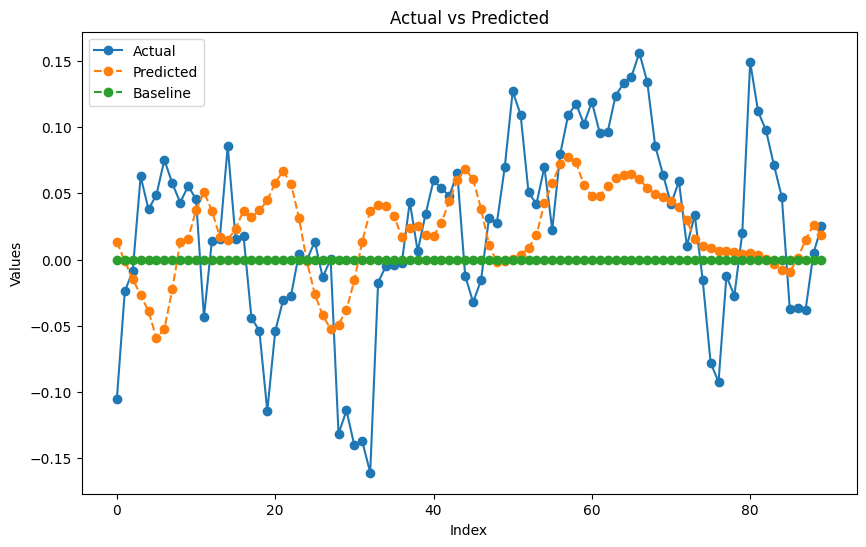

In [184]:
k=-90
m = 1
plot_actual_vs_predicted(y[k:], y_pred_train[k:]*m, y_base0_train[k:])

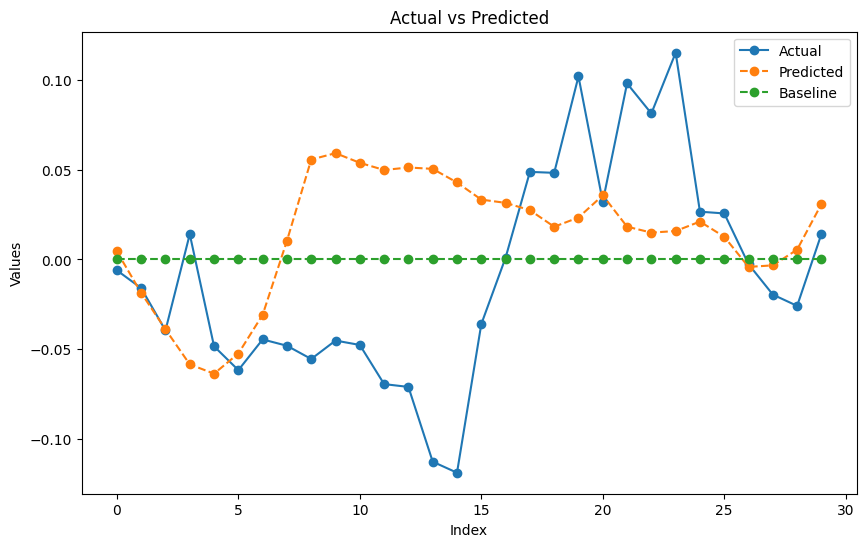

In [185]:
plot_actual_vs_predicted(y_val, y_pred_val*m, y_base0_val)

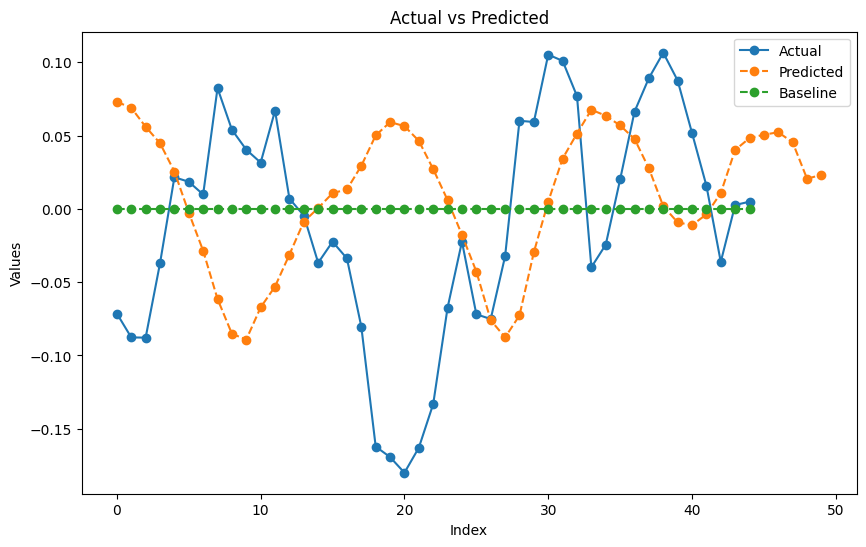

In [186]:
plot_actual_vs_predicted(y_test, y_pred_test*m, y_base0_test)

In [187]:
print('Model')
print(calculate_metrics(y, y_pred_train, y_test, y_pred_test[:-shift_], y_val, y_pred_val))
print('-----')
print('Baseline 0')
print(calculate_metrics(y, y_base0_train, y_test, y_base0_test, y_val, y_base0_val))
print('-----')
print('Baseline Prev')
print(calculate_metrics(y, y_base_train, y_test, y_base_test, y_val, y_base_val))


Model
                 MAE       MSE      RMSE  R2 Score        MAPE      MASE
Train       0.061783  0.005936  0.077048  0.141115  674.921596  1.531723
Test        0.085351  0.011153  0.105608 -0.889140  207.088216  2.116009
Validation  0.054255  0.005336  0.073046 -0.544996  278.881945  1.345085
-----
Baseline 0
                 MAE       MSE      RMSE  R2 Score   MAPE      MASE
Train       0.064894  0.006912  0.083137 -0.000003  100.0  1.608834
Test        0.062652  0.006008  0.077513 -0.017686  100.0  1.553260
Validation  0.049144  0.003530  0.059411 -0.022058  100.0  1.218378
-----
Baseline Prev
                 MAE       MSE      RMSE  R2 Score        MAPE      MASE
Train       0.085557  0.011935  0.109245 -0.726724  783.969031  2.121111
Test        0.092328  0.010375  0.101858 -0.757355  366.240721  2.288971
Validation  0.065605  0.006689  0.081784 -0.936777  545.417382  1.626482


In [188]:
#save model to h5
model.save(prefix+'_lstm_fin_cols.h5')

### Model News

In [189]:
window_size = 10
target_cols = ['target_5']
cols_used = [
            'vader_Score', 'bart_Score', 'mean_influential', 'finbert_Score', 'mean_trustworthy'
             ]
shift_ = 5

X, y, X_val, y_val, X_test, y_test, y_base_train, y_base_val, y_base_test,\
y_base0_train, y_base0_val, y_base0_test = get_x_y(train_set = train_set,
        val_set = val_set, test_set = test_set, cols_used = cols_used,
        target_cols= target_cols, window_size=10, shift_= shift_)

In [198]:
model = train_model_from_params(study_n.best_params, X, y, X_val, y_val)

Epoch 1/350
21/21 [==============================] - 8s 115ms/step - loss: 0.0069 - custom_auc: 0.4918 - val_loss: 0.0036 - val_custom_auc: 0.5000
Epoch 2/350
21/21 [==============================] - 0s 10ms/step - loss: 0.0070 - custom_auc: 0.4882 - val_loss: 0.0037 - val_custom_auc: 0.5000
Epoch 3/350
21/21 [==============================] - 0s 12ms/step - loss: 0.0069 - custom_auc: 0.5145 - val_loss: 0.0037 - val_custom_auc: 0.5000
Epoch 4/350
21/21 [==============================] - 0s 11ms/step - loss: 0.0070 - custom_auc: 0.4878 - val_loss: 0.0035 - val_custom_auc: 0.5000
Epoch 5/350
21/21 [==============================] - 0s 11ms/step - loss: 0.0069 - custom_auc: 0.4989 - val_loss: 0.0036 - val_custom_auc: 0.2222
Epoch 6/350
21/21 [==============================] - 0s 11ms/step - loss: 0.0069 - custom_auc: 0.5271 - val_loss: 0.0037 - val_custom_auc: 0.4167
Epoch 7/350
21/21 [==============================] - 0s 10ms/step - loss: 0.0069 - custom_auc: 0.5252 - val_loss: 0.0035 - 

In [199]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X)
y_pred_test = model.predict(X_test)

2/2 [==============================] - 0s 9ms/step


In [200]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y>0, y_pred_train.flatten()>0))
print(roc_auc_score(y_val>0, y_pred_val.flatten()>0))
print(roc_auc_score(y_test>0, y_pred_test[:-shift_].flatten()>0))

0.651875005992732
0.7222222222222223
0.39723320158102765


In [201]:
print(f'train')
print(count_signs_matrix(y, y_pred_train.flatten()))
print(f'val')
print(count_signs_matrix(y_val, y_pred_val.flatten()))
print(f'test')
print(count_signs_matrix(y_test, y_pred_test[:-shift_].flatten()))

train
[[184 145]
 [ 81 236]]
val
[[10  2]
 [ 7 11]]
test
[[12 11]
 [16  6]]


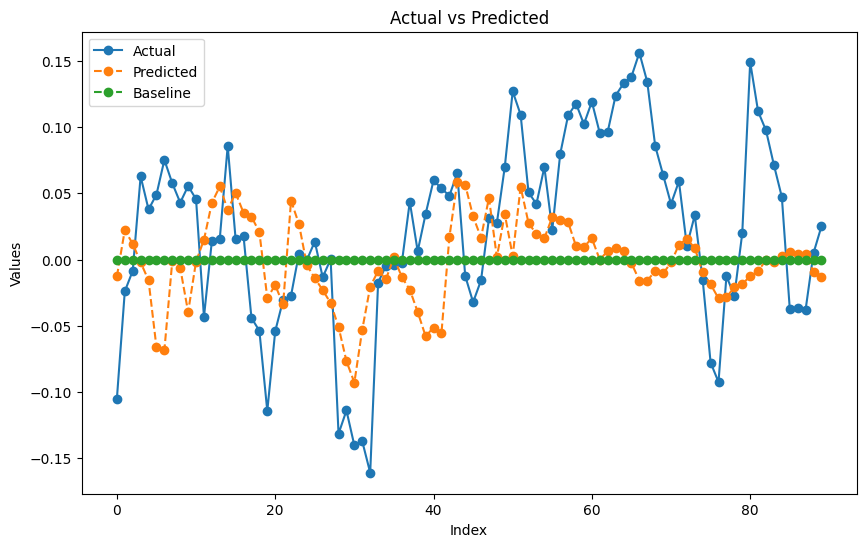

In [202]:
k=-90
m = 1
plot_actual_vs_predicted(y[k:], y_pred_train[k:]*m, y_base0_train[k:])

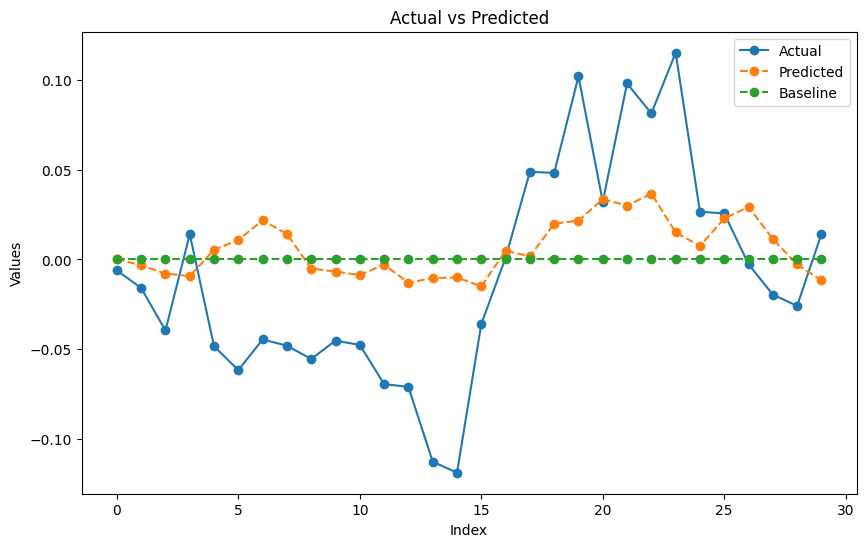

In [203]:
plot_actual_vs_predicted(y_val, y_pred_val*m, y_base0_val)

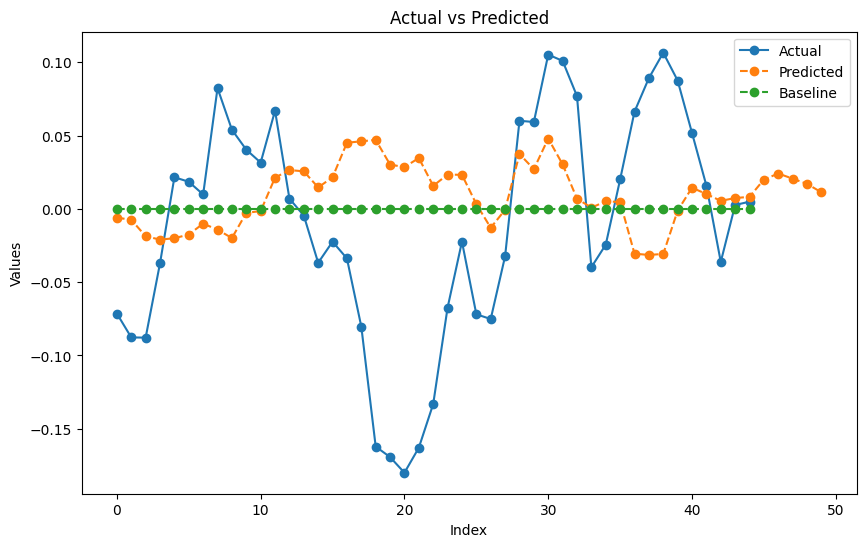

In [204]:
plot_actual_vs_predicted(y_test, y_pred_test*m, y_base0_test)

In [205]:
print('Model')
print(calculate_metrics(y, y_pred_train, y_test, y_pred_test[:-shift_], y_val, y_pred_val))
print('-----')
print('Baseline 0')
print(calculate_metrics(y, y_base0_train, y_test, y_base0_test, y_val, y_base0_val))
print('-----')
print('Baseline Prev')
print(calculate_metrics(y, y_base_train, y_test, y_base_test, y_val, y_base_val))


Model
                 MAE       MSE      RMSE  R2 Score        MAPE      MASE
Train       0.054482  0.004778  0.069127  0.308636  588.096251  1.350720
Test        0.069242  0.007728  0.087909 -0.308978  137.361608  1.716639
Validation  0.043993  0.002792  0.052844  0.191409  163.652910  1.090664
-----
Baseline 0
                 MAE       MSE      RMSE  R2 Score   MAPE      MASE
Train       0.064894  0.006912  0.083137 -0.000003  100.0  1.608834
Test        0.062652  0.006008  0.077513 -0.017686  100.0  1.553260
Validation  0.049144  0.003530  0.059411 -0.022058  100.0  1.218378
-----
Baseline Prev
                 MAE       MSE      RMSE  R2 Score        MAPE      MASE
Train       0.085557  0.011935  0.109245 -0.726724  783.969031  2.121111
Test        0.092328  0.010375  0.101858 -0.757355  366.240721  2.288971
Validation  0.065605  0.006689  0.081784 -0.936777  545.417382  1.626482


In [206]:
#save model to h5
model.save(prefix+'_lstm_news_cols.h5')

### Model Full

In [209]:
window_size = 10
target_cols = ['target_5']
cols_used = [
            'minmax_low_norm', 'minmax_high_norm', 'norm_rsi_gspc_14', 'norm_slowk_14' ,
            'vader_Score', 'bart_Score', 'mean_influential', 'finbert_Score', 'mean_trustworthy'
             ]
shift_ = 5

X, y, X_val, y_val, X_test, y_test, y_base_train, y_base_val, y_base_test,\
y_base0_train, y_base0_val, y_base0_test = get_x_y(train_set = train_set,
        val_set = val_set, test_set = test_set, cols_used = cols_used,
        target_cols= target_cols, window_size=10, shift_= shift_)

In [210]:
model = train_model_from_params(study_full.best_params, X, y, X_val, y_val)

Epoch 1/350
21/21 [==============================] - 7s 70ms/step - loss: 0.0071 - custom_auc: 0.5363 - val_loss: 0.0033 - val_custom_auc: 0.5417
Epoch 2/350
21/21 [==============================] - 0s 11ms/step - loss: 0.0067 - custom_auc: 0.5475 - val_loss: 0.0040 - val_custom_auc: 0.5000
Epoch 3/350
21/21 [==============================] - 0s 10ms/step - loss: 0.0066 - custom_auc: 0.5723 - val_loss: 0.0036 - val_custom_auc: 0.4861
Epoch 4/350
21/21 [==============================] - 0s 11ms/step - loss: 0.0065 - custom_auc: 0.5703 - val_loss: 0.0031 - val_custom_auc: 0.6528
Epoch 5/350
21/21 [==============================] - 0s 10ms/step - loss: 0.0063 - custom_auc: 0.6030 - val_loss: 0.0032 - val_custom_auc: 0.5139
Epoch 6/350
21/21 [==============================] - 0s 12ms/step - loss: 0.0067 - custom_auc: 0.5709 - val_loss: 0.0033 - val_custom_auc: 0.5000
Epoch 7/350
21/21 [==============================] - 0s 11ms/step - loss: 0.0062 - custom_auc: 0.6116 - val_loss: 0.0041 - v

In [211]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X)
y_pred_test = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [212]:
print(roc_auc_score(y>0, y_pred_train.flatten()>0))
print(roc_auc_score(y_val>0, y_pred_val.flatten()>0))
print(roc_auc_score(y_test>0, y_pred_test[:-shift_].flatten()>0))

0.6886368212631719
0.9027777777777777
0.3349802371541502


In [213]:
print(f'train')
print(count_signs_matrix(y, y_pred_train.flatten()))
print(f'val')
print(count_signs_matrix(y_val, y_pred_val.flatten()))
print(f'test')
print(count_signs_matrix(y_test, y_pred_test[:-shift_].flatten()))

train
[[203 126]
 [ 76 241]]
val
[[11  1]
 [ 2 16]]
test
[[ 6 17]
 [13  9]]


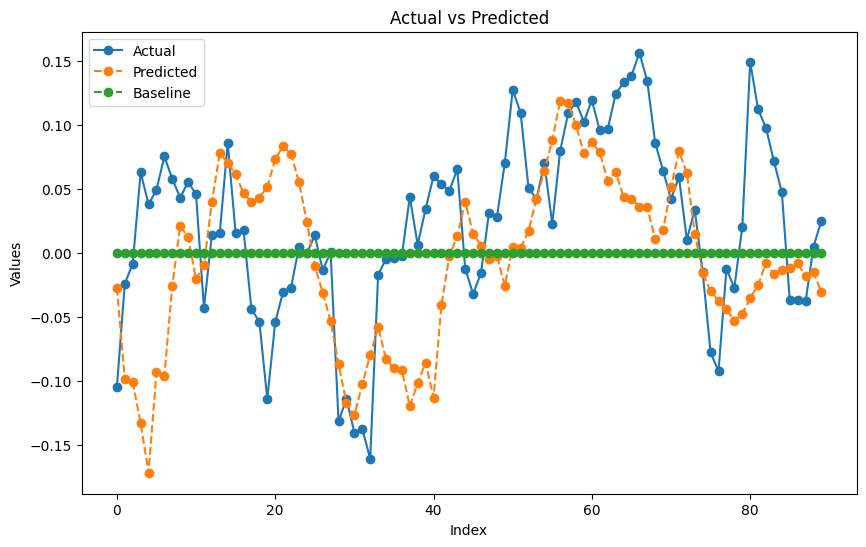

In [216]:
k=-90
m = 2
plot_actual_vs_predicted(y[k:], y_pred_train[k:]*m, y_base0_train[k:])

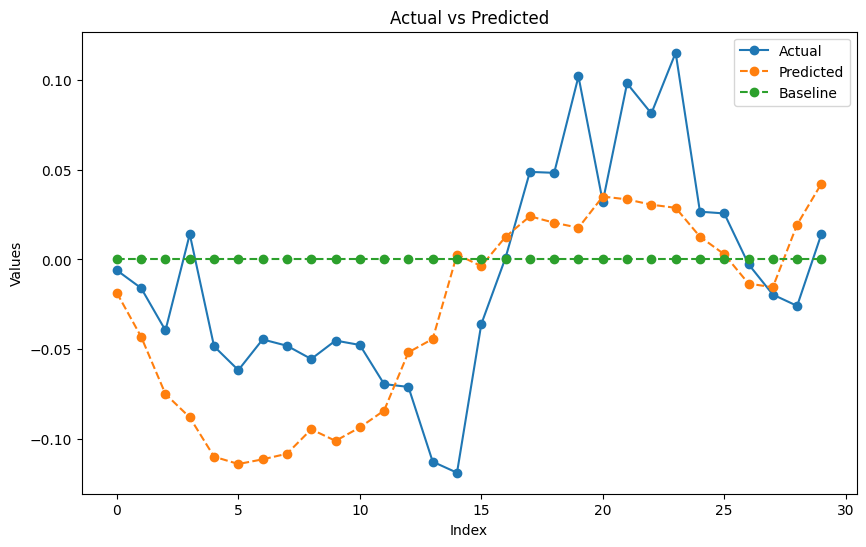

In [217]:
plot_actual_vs_predicted(y_val, y_pred_val*m, y_base0_val)

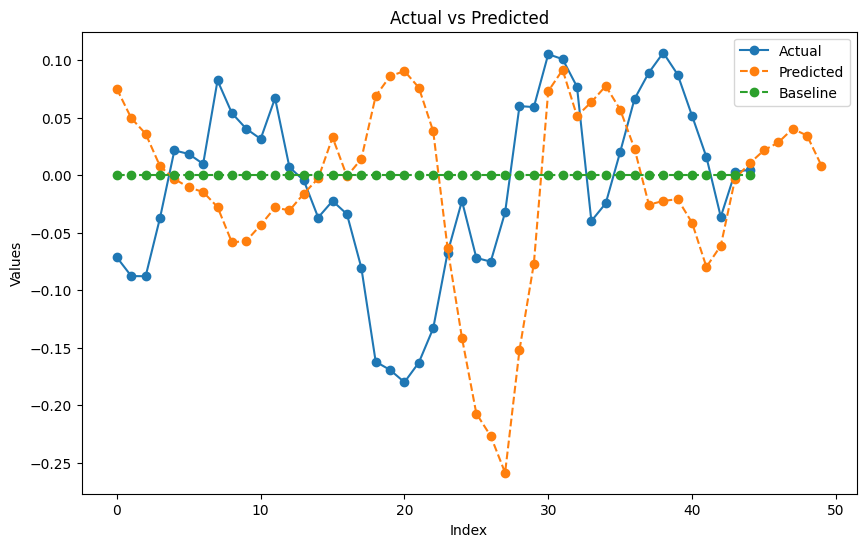

In [218]:
plot_actual_vs_predicted(y_test, y_pred_test*m, y_base0_test)

In [219]:
print('Model')
print(calculate_metrics(y, y_pred_train, y_test, y_pred_test[:-shift_], y_val, y_pred_val))
print('-----')
print('Baseline 0')
print(calculate_metrics(y, y_base0_train, y_test, y_base0_test, y_val, y_base0_val))
print('-----')
print('Baseline Prev')
print(calculate_metrics(y, y_base_train, y_test, y_base_test, y_val, y_base_val))


Model
                 MAE       MSE      RMSE  R2 Score        MAPE      MASE
Train       0.056569  0.005005  0.070745  0.275879  618.588614  1.402442
Test        0.074176  0.008620  0.092842 -0.460020  177.232850  1.838967
Validation  0.032228  0.002183  0.046725  0.367820  224.885677  0.798981
-----
Baseline 0
                 MAE       MSE      RMSE  R2 Score   MAPE      MASE
Train       0.064894  0.006912  0.083137 -0.000003  100.0  1.608834
Test        0.062652  0.006008  0.077513 -0.017686  100.0  1.553260
Validation  0.049144  0.003530  0.059411 -0.022058  100.0  1.218378
-----
Baseline Prev
                 MAE       MSE      RMSE  R2 Score        MAPE      MASE
Train       0.085557  0.011935  0.109245 -0.726724  783.969031  2.121111
Test        0.092328  0.010375  0.101858 -0.757355  366.240721  2.288971
Validation  0.065605  0.006689  0.081784 -0.936777  545.417382  1.626482


In [220]:
#save model to h5
model.save(prefix+'_lstm_full_cols.h5')